In [5]:
import pandas as pd

personality_traits = ["openness", "conscientiousness", "extroversion", "agreeableness", "neuroticism"]

counts_list = []


for trait in personality_traits:
    bins = pd.cut(
        analysis_df[trait],
        bins=[1.0, 3.6, 5.0],
        labels=["Low/Medium (<15)", "High (>=15 out of 20)"],  # Changed to match reindex
        include_lowest=True
    )

    counts = bins.value_counts().reindex(["Low/Medium (<15)", "High (>=15 out of 20)"], fill_value=0)

    counts_list.append([trait] + counts.tolist())

summary_df = pd.DataFrame(counts_list, columns=["Category", "Low/Medium (<15)", "High (>=15 out of 20)"])

print(summary_df)


            Category  Low/Medium (<15)  High (>=15 out of 20)
0           openness               107                    241
1  conscientiousness               130                    218
2       extroversion               239                    109
3      agreeableness                24                    324
4        neuroticism               231                    117


In [7]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

personality_traits = ["openness", "conscientiousness", "extroversion", "agreeableness", "neuroticism"]

independence_results = {}

for trait in personality_traits:

    bins = pd.cut(
        analysis_df[trait],
        bins=[1.0, 3.6, 5.0],
        labels=["Low (<15)", "High (>=15 out of 20)"],
        include_lowest=True
    )


    contingency = pd.crosstab(bins, analysis_df["explanation type"])


    chi2, p, dof, expected = chi2_contingency(contingency)


    n = contingency.sum().sum()
    min_dim = min(contingency.shape[0] - 1, contingency.shape[1] - 1)
    cramers_v = np.sqrt(chi2 / (n * min_dim))

    independence_results[trait] = {
        "contingency_table": contingency,
        "chi2": chi2,
        "p_value": p,
        "dof": dof,
        "cramers_v": cramers_v,
        "expected": pd.DataFrame(expected,
                                 index=contingency.index,
                                 columns=contingency.columns)
    }


p_values = [r["p_value"] for r in independence_results.values()]
sorted_indices = np.argsort(p_values)
sorted_p_values = np.array(p_values)[sorted_indices]


n_tests = len(p_values)
adjusted_p_values = np.zeros(n_tests)
for i, p in enumerate(sorted_p_values):
    adjusted_p_values[sorted_indices[i]] = min(1.0, max(p * (n_tests - i),
                                                          adjusted_p_values[sorted_indices[i-1]] if i > 0 else 0))


for i, trait in enumerate(personality_traits):
    independence_results[trait]["p_value_adjusted"] = adjusted_p_values[i]


print("=" * 80)
print("Chi-Square Tests of Independence: Personality Traits vs Explanation Type")
print("(p-values Holm-adjusted across the five tests)")
print("=" * 80)

for trait, r in independence_results.items():
    print(f"\n{trait.capitalize()}")
    print("-" * 40)
    print("Contingency table:")
    print(r["contingency_table"])
    print(f"\nχ² = {r['chi2']:.3f}, df = {r['dof']}, p = {r['p_value']:.5f}, p_adj = {r['p_value_adjusted']:.5f}")
    print(f"Cramér's V = {r['cramers_v']:.3f}")


    if r['p_value_adjusted'] < 0.001:
        sig = "***"
    elif r['p_value_adjusted'] < 0.01:
        sig = "**"
    elif r['p_value_adjusted'] < 0.05:
        sig = "*"
    else:
        sig = "ns"
    print(f"Significance: {sig}")

print("\n" + "=" * 80)
print("Note: * p < .05, ** p < .01, *** p < .001, ns = not significant (Holm-adjusted)")

Chi-Square Tests of Independence: Personality Traits vs Explanation Type
(p-values Holm-adjusted across the five tests)

Openness
----------------------------------------
Contingency table:
explanation type       Extroversion  agreeableness   conscientiousness  \
openness                                                                 
Low (<15)                        19              17                 10   
High (>=15 out of 20)            34              41                 21   

explanation type       feature based  neuroticism    openness  
openness                                                       
Low (<15)                         28             23        10  
High (>=15 out of 20)             58             49        38  

χ² = 3.134, df = 5, p = 0.67936, p_adj = 1.00000
Cramér's V = 0.095
Significance: ns

Conscientiousness
----------------------------------------
Contingency table:
explanation type       Extroversion  agreeableness   conscientiousness  \
conscientiousness 

In [9]:
import pandas as pd
from scipy.stats import chisquare
import numpy as np

personality_traits = ["openness", "conscientiousness", "extroversion", "agreeableness", "neuroticism"]

results = {}

for trait in personality_traits:

    bins = pd.cut(
        analysis_df[trait],
        bins=[1.0, 3.6, 5.0],
        labels=["Low (<15)", "High (>=15 out of 20)"],
        include_lowest=True
    )


    high_mask = (bins == "High (>=15 out of 20)")
    high_df = analysis_df.loc[high_mask]


    counts = high_df["explanation type"].value_counts(dropna=False).sort_index()


    if len(counts) >= 2:
        chi2, p = chisquare(counts)


        expected = np.repeat(counts.sum() / len(counts), len(counts))


        std_residuals = (counts.values - expected) / np.sqrt(expected)

        posthoc_df = pd.DataFrame({
            "Observed": counts.values,
            "Expected": expected,
            "Std Residual": std_residuals
        }, index=counts.index)
    else:
        chi2, p = float("nan"), float("nan")
        posthoc_df = pd.DataFrame()

    results[trait] = {
        "n_high": high_mask.sum(),
        "counts": counts,
        "chi2": chi2,
        "p_value": p,
        "posthoc": posthoc_df
    }


for trait, r in results.items():
    print(f"\n=== {trait.capitalize()} — High (>=15/20) only ===")
    print(f"N (High): {r['n_high']}")
    print(f"Chi-square: {r['chi2']:.3f}  |  p-value: {r['p_value']:.5f}")
    if not r["posthoc"].empty:
        print("\nPost hoc (standardized residuals):")
        print(r["posthoc"])



=== Openness — High (>=15/20) only ===
N (High): 241
Chi-square: 20.087  |  p-value: 0.00120

Post hoc (standardized residuals):
                   Observed   Expected  Std Residual
explanation type                                    
Extroversion             34  40.166667     -0.973011
agreeableness            41  40.166667      0.131488
conscientiousness        21  40.166667     -3.024222
feature based            58  40.166667      2.813842
neuroticism              49  40.166667      1.393772
openness                 38  40.166667     -0.341869

=== Conscientiousness — High (>=15/20) only ===
N (High): 218
Chi-square: 31.413  |  p-value: 0.00001

Post hoc (standardized residuals):
                   Observed   Expected  Std Residual
explanation type                                    
Extroversion             34  36.333333     -0.387101
agreeableness            39  36.333333      0.442401
conscientiousness        14  36.333333     -3.705108
feature based            53  36.333333    

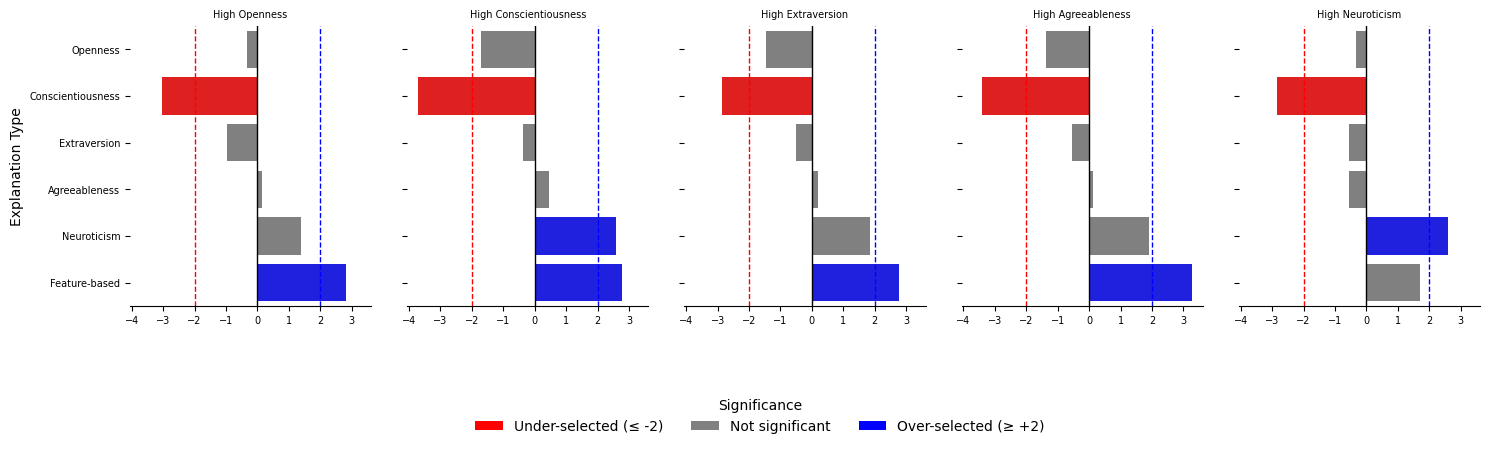

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch


OCEAN_LABELS = {
    "openness": "Openness",
    "conscientiousness": "Conscientiousness",
    "extraversion": "Extraversion",
    "extroversion": "Extraversion",
    "agreeableness": "Agreeableness",
    "neuroticism": "Neuroticism",
}


EXPL_CANON = {
    "openness": "Openness",
    "openess": "Openness",
    "conscientiousness": "Conscientiousness",
    "extraversion": "Extraversion",
    "extroversion": "Extraversion",
    "agreeableness": "Agreeableness",
    "neuroticism": "Neuroticism",
    "feature-based": "Feature-based",
    "feature based": "Feature-based",
    "feature": "Feature-based",
}


all_posthoc = []
for trait, r in results.items():
    df = r.get("posthoc", pd.DataFrame())
    if df is None or df.empty:
        continue
    df = df.copy()

    if df.index.name is None:
        df.index.name = "Explanation Type"
    df = df.reset_index()

    metric_cols = {"Observed", "Expected", "Std Residual"}
    expl_col = None
    for c in df.columns:
        if c not in metric_cols:
            expl_col = c
            break
    if expl_col is None:
        raise ValueError("Could not detect the explanation type column in posthoc DataFrame.")
    if expl_col != "Explanation Type":
        df = df.rename(columns={expl_col: "Explanation Type"})

    df["Explanation Type"] = (
        df["Explanation Type"]
        .astype(str).str.strip().str.lower()
        .map(EXPL_CANON)
        .fillna(df["Explanation Type"])
    )

    df["Trait"] = OCEAN_LABELS.get(str(trait).lower(), str(trait).capitalize())
    all_posthoc.append(df)

if not all_posthoc:
    raise ValueError("No non-empty posthoc tables found in `results`.")

all_posthoc_df = pd.concat(all_posthoc, ignore_index=True)
all_posthoc_df["Std Residual"] = pd.to_numeric(all_posthoc_df["Std Residual"], errors="coerce")


preferred_order = ["Openness", "Conscientiousness", "Extraversion", "Agreeableness", "Neuroticism", "Feature-based"]
present = list(all_posthoc_df["Explanation Type"].dropna().unique())
order_expl = [x for x in preferred_order if x in present] + [x for x in present if x not in preferred_order]



def sig_bucket(x: float) -> str:
    if pd.isna(x):
        return "Not significant"
    if x > 2:
        return "Over-selected (≥ +2)"
    if x < -2:
        return "Under-selected (≤ -2)"
    return "Not significant"

all_posthoc_df["Significance"] = all_posthoc_df["Std Residual"].apply(sig_bucket)

hue_order = ["Under-selected (≤ -2)", "Not significant", "Over-selected (≥ +2)"]
palette = {
    "Under-selected (≤ -2)": "red",
    "Not significant": "gray",
    "Over-selected (≥ +2)": "blue",
}

g = sns.catplot(
    data=all_posthoc_df,
    x="Std Residual", y="Explanation Type",
    col="Trait", kind="bar",
    hue="Significance", hue_order=hue_order,
    order=order_expl, dodge=False,
    height=4.2, aspect=1.0,
    palette=palette, errorbar=None,
    legend=False
)




g.fig.set_size_inches(15, 4)




for ax in g.axes.flatten():
    ax.axvline(0, color="black", linewidth=1)
    ax.axvline(2, color="blue", linestyle="--", linewidth=1)
    ax.axvline(-2, color="red", linestyle="--", linewidth=1)
    ax.tick_params(labelsize=7)

g.set_titles("High {col_name}", size=7)
g.set_axis_labels("", "Explanation Type")
g.despine(left=True)


present_hues = [h for h in hue_order if h in all_posthoc_df["Significance"].unique()]
handles = [Patch(label=h, facecolor=palette[h]) for h in present_hues]
g.fig.legend(
    handles,
    [h for h in present_hues],
    title="Significance",
    loc="lower center",
    ncol=min(3, len(present_hues)),
    frameon=False,
    bbox_to_anchor=(0.5, -0.15)
)


g.fig.subplots_adjust(left=0.08, right=0.98, top=0.90, bottom=0.20, wspace=0.15)

plt.show()
